# TF-IDF

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import string
import requests
import io
import nltk
from zipfile import ZipFile
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodecsv

In [19]:
sess=tf.Session()
batch_size=200
max_features=1000

In [20]:
#load the data
save_file_name=os.path.join('temp','temp_spam_data.csv')

In [21]:
if os.path.isfile(save_file_name):
    text_data=[]
    with open(save_file_name,'r') as temp_output_file:
        reader=csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url='http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r=requests.get(zip_url)
    z=ZipFile(io.BytesIO(r.content))
    file=z.read('SMSSpamCollection')
    #Format Data
    text_data=file.decode('utf8')
    text_data=text_data.encode('utf8',errors='ignore')
    text_data=text_data.decode('utf8').split('\n')
    text_data=[x.split('\t') for x in text_data if len(x)>=1]
    
    with open(save_file_name,'w') as temp_output_file:
        writer=unicodecsv.writer(temp_output_file,encoding='utf-8')
        writer.writerows(text_data)

In [22]:
texts=[x[1] for x in text_data]
target=[x[0] for x in text_data]
target=[1. if x=='spam' else 0. for x in target]

In [23]:
# standardize the words
# Lower case
texts=[x.lower() for x in texts]
# Remove punctuation
texts=[''.join(c for c in x if c not in string.punctuation) for x in texts]
# Trim extra whitespace
texts=[' '.join(x.split()) for x in texts]

In [24]:
def tokenizer(text):
    words=nltk.word_tokenize(text)
    return words

In [25]:
#Create TF-IDF of texts
tfidf=TfidfVectorizer(tokenizer=tokenizer,stop_words='english',max_features=max_features)
sparse_tfidf_texts=tfidf.fit_transform(texts)

In [27]:
temp=sparse_tfidf_texts.todense()

In [28]:
# Break data into train and test set
train_indices=np.random.choice(sparse_tfidf_texts.shape[0],round(0.8*sparse_tfidf_texts.shape[0]),replace=False)
test_indices=np.array(list(set(range(sparse_tfidf_texts.shape[0]))-set(train_indices)))
texts_train=sparse_tfidf_texts[train_indices]
texts_test=sparse_tfidf_texts[test_indices]
target_train=np.array([x for ix,x in enumerate(target) if ix in train_indices])
target_test=np.array([x for ix,x in enumerate(target) if ix in test_indices])

/Users/edwin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [29]:
A=tf.Variable(tf.random_normal(shape=[max_features,1]))
b=tf.Variable(tf.random_normal(shape=[1,1]))
# Initialize placeholders
x_data = tf.placeholder(shape=[None,max_features],dtype=tf.float32)
y_target = tf.placeholder(shape=[None,1],dtype=tf.float32)

In [30]:
model_output=tf.add(tf.matmul(x_data,A),b)
loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output,labels=y_target))

In [31]:
prediction = tf.round(tf.sigmoid(model_output))
prediction_correct = tf.cast(tf.equal(prediction,y_target),tf.float32)
accuracy = tf.reduce_mean(prediction_correct)

In [32]:
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)
#Initialize Variables
init=tf.global_variables_initializer()
sess.run(init)

In [36]:
# Model training

train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    
    rand_index=np.random.choice(texts_train.shape[0],size=batch_size)
    rand_x=texts_train[rand_index].todense()
    rand_y=np.transpose([target_train[rand_index]])
    sess.run(train_step,feed_dict={x_data:rand_x,y_target:rand_y})
    
    if (i+1)%100==0:
        
        i_data.append(i+1)
        train_loss_temp = sess.run(loss,feed_dict={x_data:rand_x,y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss,feed_dict={x_data:texts_test.todense(),y_target:np.transpose([target_test])})
        print texts_test.shape
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data:rand_x, y_target:rand_y})
        train_acc.append(train_acc_temp)
        
        test_acc_temp=sess.run(accuracy,feed_dict={x_data:texts_test.todense(),y_target:np.transpose([target_test])})
        test_acc.append(test_acc_temp)
        
        if (i+1) % 500 ==0:
            acc_and_loss = [i+1,train_loss_temp,test_loss_temp,train_acc_temp,test_acc_temp]
            acc_and_loss = [np.round(x,2) for x in acc_and_loss]
            print('Generation # {}. Train Loss (Test Loss) : {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 500. Train Loss (Test Loss) : 0.43 (0.47). Train Acc (Test Acc): 0.87 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 1000. Train Loss (Test Loss) : 0.43 (0.47). Train Acc (Test Acc): 0.86 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 1500. Train Loss (Test Loss) : 0.41 (0.47). Train Acc (Test Acc): 0.86 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 2000. Train Loss (Test Loss) : 0.42 (0.47). Train Acc (Test Acc): 0.88 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 2500. Train Loss (Test Loss) : 0.46 (0.47). Train Acc (Test Acc): 0.86 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
Generation # 3000. Train Loss (Test Loss) : 0.47 (0.47). Train Acc (Test Acc): 0.83 (0.85)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)
(1115, 1000)


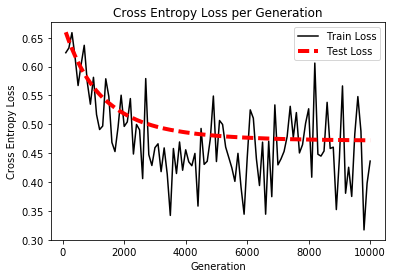

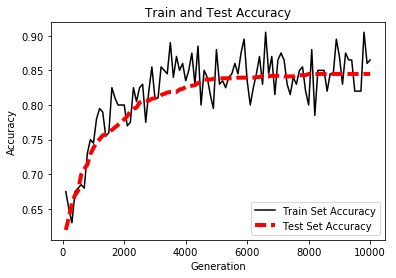

In [34]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()